<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Alpha_Beta_Crown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for α,β-CROWN Robustness Verification 





---


*This tutorial shows the robustness verification of a neural network trained on 
the MNIST dataset with use of α,β-CROWN.*


---

**This is a interactive tutorial. So feel free to experiment and change stuff. In every spot we think it would be intersting to change some stuff around we put this little icon.**

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Edit_icon_%28the_Noun_Project_30184%29.svg/1024px-Edit_icon_%28the_Noun_Project_30184%29.svg.png" alt="drawing" width="50"/>

---


##Why do we need to verify neural networks? 
Nowadays, neural networks are used in safety-critical areas, among others. As a result, there is a need to formally prove some of the network's behaviours (especially under malicious inputs). \\
One of those behaviours is the so-called **Robustness** of the network. Robustness means that small perturbations to the inputs should not lead to changes in the output of the neural network. \\
![img](https://openai.com/content/images/2017/02/adversarial_img_1.png) \\
The illustration shows, for example, image recognition for an animal. On the left side, the neural network recognises a panda with a probability of 57.7%. By adding noise, a gibbon is recognised in the following with a probability of 99.3%. In this example, this wrong decision is probably not safety-critical, but other use cases (for example in the field of autonomous driving) are conceivable where such a wrong decision could have serious consequences.


##Basics on α,β-CROWN

The basic idea behind α,β-CROWN is to use efficient bound propagation for verification tasks based on *Automatic Linear Relaxation based Perturbation Analysis for Neural Networks* (LiRPA). The [code](https://github.com/KaidiXu/auto_LiRPA) of LiRPA can be found on github. \\
In the picture below one can see the concept of LiRPA. The input to a neural network or any general computations consists of data or model weights under perturbations. That refers to the image with the panda above. We want to allow pictures as input that are slightly different, but then then the network should predict the same classification output. 
![img](https://camo.githubusercontent.com/86e55db4461fc54896a582f0c275c1d4f02f2ffd9159d3c6e9d4fcfa9744d854/687474703a2f2f7777772e6875616e2d7a68616e672e636f6d2f696d616765732f75706c6f61642f6c697270612f6175746f5f4c695250415f6261636b67726f756e645f332e706e67) \\
The output of LiRPA are a set of output bounds, which are the guaranteed score ranges for different classification outputs of the neural network. 

**Complete verification** In a complete verification setting the verifier should say "yes" or "no" to a given property of a network. \\
**α,β-CROWN**
α,β-CROWN is an open-source neural network verifier based on an efficient bound propagation algorithm and branch and bound. The code can be found on [their website](https://github.com/huanzhang12/alpha-beta-CROWN). \\
**CROWN** is a general framework to certify robustness of
neural networks with general activation functions for given input data points. The algorithm can be used for certifying NNs using linear or quadratic
upper and lower bounds for general activation functions that are not necessarily piece-wise linear.[See their paper for more information](https://arxiv.org/pdf/1811.00866.pdf). \\
**β-CROWN** is a "new bound propagation based method that can fully encode neuron splits via optimizable parameters
β constructed from either primal or dual space". [See the paper of β-CROWN for more information](https://arxiv.org/pdf/2103.06624.pdf). \\
**α-CROWN** is for incomplete verification with optimized CROWN bound. [See the paper of α-CROWN for more information](https://arxiv.org/pdf/2011.13824.pdf). \\


In this tutorial we will first go through the installation of α,β-CROWN. Then we will see some of the features and configuration options of α,β-CROWN.

## Installation

This installation is based on another [tutorial](https://colab.research.google.com/drive/1mJTOmq2qHxMycHUzBepBN47QWcxda3ov#scrollTo=Y0toepwVIFTG). 

First we will set up our miniconda environment. 

In [1]:
%%capture
%%bash
%env PYTHONPATH=
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

Python in version 3.7 is installed into the environment. 

In [2]:
%%capture
%%bash
conda install --channel defaults conda python=3.7 --yes
conda update --channel defaults --all --yes

In [3]:
%%capture
import sys
sys.path
!ls /usr/local/lib/python3.7/dist-packages
_ = (sys.path
        .append("/usr/local/lib/python3.7/site-packages"))

In order to use the library, we have to clone the corresponding git-repository.

In [4]:
%%capture
# Uninstall existing Pytorch on Colab, which might be incompatible or buggy.
# Note that the alpha beta crown library is tested on Pytorch 1.8.2 LTS, and other versions might be incompatible.(according to reference tutorial)
# !pip uninstall --yes torch torchvision torchaudio torchtext
!git clone https://github.com/huanzhang12/alpha-beta-CROWN.git

The environment is created. 

In [5]:
%%capture
%%bash
# Remove the old environment, if necessary.
conda env remove --name alpha-beta-crown
conda env create -f alpha-beta-CROWN/complete_verifier/environment.yml  # install all dependents into the alpha-beta-crown environment

In [6]:
%cd alpha-beta-CROWN/complete_verifier/

/content/alpha-beta-CROWN/complete_verifier


As explained on [the website of the α,β-project](https://github.com/huanzhang12/alpha-beta-CROWN), it is nessasary to create a configuration file in order to load the data. 

## Configure verification

Now we want to verifiy a neural network. Therefore, we create a file called my_example_config.yaml which configures parameters for verification. 
The model is defined as followed: 


```
def mnist_6_100():
    model = nn.Sequential(
        Flatten(),
        nn.Linear(784,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
    return model
```

It contains six linear layers and uses the ReLU activation function.

We start with a very basic configuration file, which means that most parameters are set to default.
The network is trained to classify input from the MNIST dataset. The MNIST dataset consists of images of handwritten digits as shown below. \\
![img](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/320px-MnistExamples.png) \\
If we now have one image from the dataset (for example a 5 shown on the left in the picture below), we want the network to classify a slightly changed image (the 7 on the right) to also be classified as a 5 (and not, as in this case, as a 3). \\
![img](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRf-yaAECy1V4PR9Po2o8cV7BOqug_-SODrtg&usqp=CAU) 

In [7]:
%%writefile exp_configs/my_example_config.yaml
general:
  # device to run verifier
  device: cpu 
  # Complete verification verifier. 
  # "bab": branch and bound with beta-CROWN; 
  # "mip": mixed integer programming (MIP) formulation; 
  # "bab-refine": branch and bound with intermediate layer bounds computed by MIP.
  complete_verifier: bab
model:
  # name of the model (provided by library, see above)
  name: mnist_6_100
  # Load pretrained model from this specified path.
  path: models/eran/mnist_6_100_nat.pth
data:
  # Dataset name. Dataset must be defined in utils.py.
  dataset: MNIST_ERAN_UN
  # Std vector used in data preprocessing.
  std: [1.0]
  # Mean vector used in data preprocessing.
  mean: [0.0]
specification:
  # Set perturbation size (Lp norm). 
  # If not set, a default value may be used based on dataset loader.
  epsilon: 0.026
solver:
  alpha-crown:
    # Number of iterations for alpha-CROWN incomplete verifier.
    iteration: 10
attack:
  # Early stop PGD when an adversarial example is found.
  pgd_early_stop: true  

Writing exp_configs/my_example_config.yaml


## Verification of network with α,β-CROWN

Now we only have to run our verification. 

First, we activate our environment.
Then we call the robustness_verifier on our configured yaml-file. The robustness_verifier is a class provided by the α,β-CROWN-library for Lp norm robustness verification and is often used to certify the robustness of a neural network. 
By setting start to 0 and end to 3, we indicate that only images 0 to 3 from the dataset should be verified. This is done for performance reasons. 
We finish by deactivating the environment.


In [8]:
%%writefile run.sh

source activate alpha-beta-crown
python robustness_verifier.py --config exp_configs/my_example_config.yaml --start 0 --end 3
conda deactivate

Writing run.sh


In [9]:
!chmod 777 run.sh
!./run.sh


EnvironmentNameNotFound: Could not find conda environment: alpha-beta-crown
You can list all discoverable environments with `conda info --envs`.


Traceback (most recent call last):
  File "robustness_verifier.py", line 23, in <module>
    from utils import get_test_acc, load_model, load_verification_dataset
  File "/content/alpha-beta-CROWN/complete_verifier/utils.py", line 20, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'


## Try configuration options

α,β-CROWN provides a number of different parameters that can be used for verification. An overview is given here: 


```
general:
  device: cuda  # Select device to run verifier, cpu or cuda (GPU).
  seed: 100  # Random seed.
  conv_mode: patches  # Convolution mode during bound propagation: "patches" mode (default) is very efficient, but may not support all architecture; "matrix" mode is slow but supports all architectures.
  deterministic: false  # Run code in CUDA deterministic mode, which has slower performance but better reproducibility.
  double_fp: false  # Use double precision floating point. GPUs with good double precision support are preferable (NVIDIA P100, V100, A100; AMD Radeon Instinc MI50, MI100).
  loss_reduction_func: sum  # When batch size is not 1, this reduction function is applied to reduce the bounds into a single number (options are "sum" and "min").
  mode: verified-acc  # Verify against all labels ("verified-acc" mode), or just the runnerup labels ("runnerup" mode), or using a specified label in dataset ("speicify-target" mode, only used for oval20). Mode can also be set as "crown-only-verified-acc" or "alpha-crown-only-verified-acc", which quickly computes the verified accuracy over the entire dataset via CROWN or alpha-CROWN.
  complete_verifier: bab  # Complete verification verifier. "bab": branch and bound with beta-CROWN; "mip": mixed integer programming (MIP) formulation; "bab-refine": branch and bound with intermediate layer bounds computed by MIP.
  enable_incomplete_verification: true  # Enable/Disable initial alpha-CROWN incomplete verification (this can save GPU memory when disabled).
model:
  path: null  # Load pretrained model from this specified path.
  name: please_specify_model_name  # Name of model. Model must be defined in the load_verification_dataset() function in utils.py.
data:
  start: 0  # Start from the i-th property in specified dataset.
  end: 10000  # End with the (i-1)-th property in the dataset.
  num_outputs: 10  # Number of classes for classification problem.
  mean: 0.0  # Mean vector used in data preprocessing.
  std: 1.0  # Std vector used in data preprocessing.
  pkl_path: null  # Load properties to verify from a .pkl file (only used for oval20 dataset).
  dataset: CIFAR  # Dataset name. Dataset must be defined in utils.py.
  data_idx_file: null  # A text file with a list of example IDs to run.
specification:
  type: lp  # Type of verification specification. "lp" = L_p norm, "bounds" = element-wise lower and upper bound provided by dataloader.
  norm: .inf  # Lp-norm for epsilon perturbation in robustness verification (1, 2, inf).
  epsilon: null  # Set perturbation size (Lp norm). If not set, a default value may be used based on dataset loader.
solver:
  alpha-crown:
    lr_alpha: 0.1  # Learning rate for the optimizable parameter alpha in alpha-CROWN bound.
    iteration: 100  # Number of iterations for alpha-CROWN incomplete verifier.
    share_slopes: false  # Share some alpha variables to save memory at the cost of slightly looser bounds.
    no_joint_opt: false  # Run alpha-CROWN bounds without joint optimization (only optimize alpha for the last layer bound).
  beta-crown:
    batch_size: 64  # Batch size in beta-CROWN (number of parallel splits).
    lr_alpha: 0.01  # Learning rate for optimizing alpha during branch and bound.
    lr_beta: 0.05  # Learning rate for optimizing beta during branch and bound.
    lr_decay: 0.98  # Learning rate decay factor during optimization. Need to use a larger value like 0.99 or 0.995 when you increase the number of iterations.
    optimizer: adam  # Optimizer used for alpha and beta optimization.
    iteration: 50  # Number of iteration for optimizing alpha and beta during branch and bound.
  mip:
    parallel_solvers: null  # Number of multi-processes for mip solver. Each process computes a mip bound for an intermediate neuron. Default (None) is to auto detect the number of CPU cores (note that each process may use multiple threads, see the next option).
    solver_threads: 1  # Number of threads for echo mip solver process (default is to use 1 thread for each solver process).
    refine_neuron_timeout: 15  # MIP timeout threshold for improving each intermediate layer bound (in seconds).
    refine_neuron_time_percentage: 0.8  # Percentage (x100%) of time used for improving all intermediate layer bounds using mip. Default to be 0.8*timeout.
bab:
  max_domains: 200000  # Max number of subproblems in branch and bound.
  decision_thresh: 0  # Decision threshold of lower bounds. When lower bounds are greater than this value, verification is successful. Set to 0 for robustness verification.
  timeout: 360  # Timeout (in second) for verifying one image/property.
  branching:
    method: kfsb  # Branching heuristic. babsr is fast but less accurate; fsb is slow but most accurate; kfsb is usualy a balance.
    candidates: 3  # Number of candidates to consider when using fsb or kfsb. More leads to slower but better branching.
    reduceop: min  # Reduction operation to compute branching scores from two sides of a branch (min or max). max can work better on some models.
attack:
  pgd_order: before  # Run PGD before/after incomplete verification, or skip it.
  enable_mip_attack: false  # Use MIP (Gurobi) based attack if PGD cannot find a successful adversarial example.
  pgd_steps: 100  # Steps of PGD attack.
  pgd_restarts: 30  # Number of random PGD restarts.
  pgd_early_stop: true  # Early stop PGD when an adversarial example is found.
  pgd_lr_decay: 0.99  # Learning rate decay factor used in PGD attack.
  pgd_alpha: auto  # Step size of PGD attack. Default (auto) is epsilon/4.
  ```



##Try out another epsilon
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Edit_icon_%28the_Noun_Project_30184%29.svg/1024px-Edit_icon_%28the_Noun_Project_30184%29.svg.png" alt="drawing" width="50"/>

Now it's up to you! Try different configuration options and see how it influences the result! \\
For example: What do you think changes with a changed value for Epsilon? 
(Expand the cell in order to see the resulting configuration file)

In [10]:
%%writefile exp_configs/my_example_config.yaml
general:
  # device to run verifier
  device: cpu 
  # Complete verification verifier. 
  # "bab": branch and bound with beta-CROWN; 
  # "mip": mixed integer programming (MIP) formulation; 
  # "bab-refine": branch and bound with intermediate layer bounds computed by MIP.
  complete_verifier: bab
model:
  # name of the model (provided by library, see above)
  name: mnist_6_100
  # Load pretrained model from this specified path.
  path: models/eran/mnist_6_100_nat.pth
data:
  # Dataset name. Dataset must be defined in utils.py.
  dataset: MNIST_ERAN_UN
  # Std vector used in data preprocessing.
  std: [1.0]
  # Mean vector used in data preprocessing.
  mean: [0.0]
specification:
  # Set perturbation size (Lp norm). 
  # If not set, a default value may be used based on dataset loader.
  epsilon: 1
solver:
  alpha-crown:
    # Number of iterations for alpha-CROWN incomplete verifier.
    iteration: 10  
attack:
  # Early stop PGD when an adversarial example is found.
  pgd_early_stop: true   

Overwriting exp_configs/my_example_config.yaml


## Run your new configuration file
So, what do you expect with your new epsilon? 

In [11]:
!./run.sh


EnvironmentNameNotFound: Could not find conda environment: alpha-beta-crown
You can list all discoverable environments with `conda info --envs`.


Traceback (most recent call last):
  File "robustness_verifier.py", line 23, in <module>
    from utils import get_test_acc, load_model, load_verification_dataset
  File "/content/alpha-beta-CROWN/complete_verifier/utils.py", line 20, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'


As you can see, the larger epsilon makes the attack much more likely to succeed. This is because a larger epsilon allows a greater change in the original image.

##Different norms
α,β-CROWN offers the possibility to use different norms for the verification of the networks. 
###L1 Norm
The L1 norm is also known as Manhattan Distance or Taxicab norm. The L1 norm for a vector $x$ is calculated by $||x||_1$=  $\sum\nolimits_{i=1}^n |x_i|$. In the case of the plot below it is $||a||_1$=  $|a_1| + |a_2|$ = 3 + 4 = 7. 



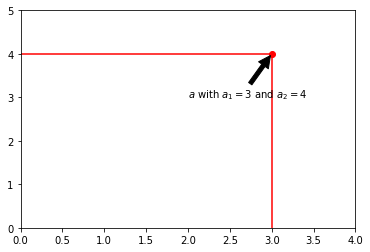

In [12]:
import matplotlib.pyplot as plt

plt.plot([3], [4], 'ro')
plt.axis([0, 4, 0, 5])
plt.plot([3, 0], [4, 4],color="red")
plt.plot([3, 3], [0, 4],color="red")
plt.annotate('$a$ with $a_1=3$ and $a_2=4$', xy=(3, 4), xytext=(2, 3),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.show()

###L2 Norm
The L2 norm is also known as the Euclidean norm. It is defined as $||x||_2 = \sqrt{\sum\nolimits_{i=1}^n |x_i|^2}$.

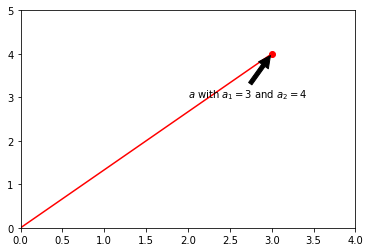

In [13]:
import matplotlib.pyplot as plt

plt.plot([3], [4], 'ro')
plt.axis([0, 4, 0, 5])
plt.plot([0, 3], [0, 4],color="red")
plt.annotate('$a$ with $a_1=3$ and $a_2=4$', xy=(3, 4), xytext=(2, 3),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.show()

###L3 Norm
The L3 norm oder maximum norm corresponds to the magnitude of the largest component of the vector.
It is defined as $||x||_{\inf} = max_{i=1,..,n}|x_i|$.

##Different norms in verification

As adversarial robustness around a fixed input $\overrightarrow{y*}$ is defined such that the distance between  $\overrightarrow{y*}$ and any $\overrightarrow{x}$ less than or equal to an epsilon always produces the same prediction. The distance here is calculated using one of the vector norms. 

###Now it's your turn
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Edit_icon_%28the_Noun_Project_30184%29.svg/1024px-Edit_icon_%28the_Noun_Project_30184%29.svg.png" alt="drawing" width="50"/>

Play around with different norms in your configuration file and run the verification.

In [14]:
%%writefile exp_configs/my_example_config.yaml
general:
  device: cpu 
  complete_verifier: bab
model:
  name: mnist_6_100
  path: models/eran/mnist_6_100_nat.pth
data:
  dataset: MNIST_ERAN_UN
  std: [1.0]
  mean: [0.0]
specification:
  ###################
  # inserted here:
  norm: .inf  
  # norm: 1
  # norm: 2
  ###################
  epsilon: 0.026
solver:
  alpha-crown:
    iteration: 10
attack:
  pgd_early_stop: true  

Overwriting exp_configs/my_example_config.yaml
